### NBDC Data Loading Helper Functions

In [2]:
import os, re, io, gzip, requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import norm, skew
import folium
import fiona

### local imports ###
from nbdc_statistical_analyses import get_warm_season_data

Cannot find header.dxf (GDAL_DATA is not defined)


In [3]:
BASE = "https://www.ndbc.noaa.gov/data/historical/stdmet/"

def list_station_files(station_id: str):
    "noaa scraper that returns .gz files"
    r = requests.get(BASE)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    urls = []
    for a in soup.find_all("a", href=True):
        h = a["href"]
        if h.startswith(f"{station_id}h") and h.endswith(".txt.gz"):
            urls.append(urljoin(BASE, h))
    return sorted(urls)

def fetch_file(url, cache_dir="cache"):
    "downloaded once and can be reused from cache"
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, os.path.basename(url))
    if not os.path.exists(fname):
        r = requests.get(url)
        r.raise_for_status()
        with open(fname, "wb") as f:
            f.write(r.content)
    return fname

def read_stdmet_max(url):
    "atmp data from noaa that returns (max atmp, year) if not returns none"
    m = re.search(r"(\d{4})\.txt\.gz", url)
    if not m:
        return None
    year = int(m.group(1))

    fname = fetch_file(url)
    with gzip.open(fname, "rt", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header = None
    for ln in reversed(lines):
        if ln.startswith("#"):
            toks = ln.lstrip("#").strip().split()
            if "MM" in toks and "DD" in toks:
                header = toks
                break
    if not header or "ATMP" not in [h.upper() for h in header]:
        return None

    colnames = [c.lstrip("#").upper() for c in header]

    #de-duplicating names
    seen, unique_cols = {}, []
    for c in colnames:
        if c in seen:
            seen[c] += 1
            c = f"{c}_{seen[c]}"
        else:
            seen[c] = 0
        unique_cols.append(c)

    df = pd.read_csv(
        io.StringIO("".join(lines)),
        sep=r"\s+",
        comment="#",
        header=None,
        names=unique_cols,
        usecols=lambda c: c == "ATMP",
        na_values=["MM", "MM.MM", "99.0", "999.0", "9999.0"],
        engine="python",
    )

    if df["ATMP"].dropna().empty:
        return None

    return year, float(df["ATMP"].max())

def read_stdmet_min(url):
    "atmp data from noaa that returns (max atmp, year) if not returns none"
    m = re.search(r"(\d{4})\.txt\.gz", url)
    if not m:
        return None
    year = int(m.group(1))

    fname = fetch_file(url)
    with gzip.open(fname, "rt", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header = None
    for ln in reversed(lines):
        if ln.startswith("#"):
            toks = ln.lstrip("#").strip().split()
            if "MM" in toks and "DD" in toks:
                header = toks
                break
    if not header or "ATMP" not in [h.upper() for h in header]:
        return None

    colnames = [c.lstrip("#").upper() for c in header]

    #de-duplicating names
    seen, unique_cols = {}, []
    for c in colnames:
        if c in seen:
            seen[c] += 1
            c = f"{c}_{seen[c]}"
        else:
            seen[c] = 0
        unique_cols.append(c)

    df = pd.read_csv(
        io.StringIO("".join(lines)),
        sep=r"\s+",
        comment="#",
        header=None,
        names=unique_cols,
        usecols=lambda c: c == "ATMP",
        na_values=["MM", "MM.MM", "99.0", "999.0", "9999.0"],
        engine="python",
    )

    if df["ATMP"].dropna().empty:
        return None

    return year, float(df["ATMP"].min())

def collect_station_max(station, workers=6):
    "process all files for a station in parallel, return series of annual maxima."
    urls = list_station_files(station)
    print(f"Found {len(urls)} files for station {station}")
    annual = {}
    with ThreadPoolExecutor(max_workers=workers) as ex:
        for res in ex.map(read_stdmet_max, urls):
            if res is None:
                continue
            yr, val = res
            annual[yr] = val
    return pd.Series(annual).sort_index()

def collect_station_min(station, workers=6):
    "process all files for a station in parallel, return series of annual maxima."
    urls = list_station_files(station)
    print(f"Found {len(urls)} files for station {station}")
    annual = {}
    with ThreadPoolExecutor(max_workers=workers) as ex:
        for res in ex.map(read_stdmet_min, urls):
            if res is None:
                continue
            yr, val = res
            annual[yr] = val
    return pd.Series(annual).sort_index()


def read_stdmet_full(url):
    """
    Parse NOAA NDBC stdmet files into DataFrame with date, year, day_of_year, ATMP.
    Handles both 'YY' and 'YYYY' header formats and variable whitespace.
    """
    import io, gzip, re
    from datetime import datetime
    import pandas as pd

    m = re.search(r"(\d{4})\.txt\.gz", url)
    if not m:
        print(f"⚠️ Could not extract year from {url}")
        return None
    year = int(m.group(1))
    fname = fetch_file(url)

    # --- Read file ---
    try:
        with gzip.open(fname, "rt", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
    except Exception as e:
        print(f"⚠️ Could not read {year}: {e}")
        return None

    # --- Detect header line ---
    header = None
    for ln in lines:
        if (("YY" in ln) or ("YYYY" in ln)) and ("MM" in ln) and ("ATMP" in ln):
            header = ln.strip().replace("#", "").split()
            break

    if not header:
        print(f"⚠️ Skipping {year}: no valid header found.")
        return None

    # --- Normalize header ---
    header = [h.replace("YYYY", "YY") for h in header]
    seen = {}
    unique_cols = []
    for c in header:
        if c in seen:
            seen[c] += 1
            unique_cols.append(f"{c}_{seen[c]}")
        else:
            seen[c] = 0
            unique_cols.append(c)

    # --- Parse data section ---
    try:
        df = pd.read_csv(
            io.StringIO("".join(lines)),
            sep=r"\s+",
            comment="#",
            names=unique_cols,
            header=None,
            engine="python",
            na_values=["MM", "MM.MM", "99.0", "99.00", "999.0", "9999.0"]
        )
    except Exception as e:
        print(f"⚠️ Failed to parse {year}: {e}")
        return None

    # --- Sanity check ---
    if "YY" not in df.columns or "MM" not in df.columns or "DD" not in df.columns or "ATMP" not in df.columns:
        print(f"⚠️ Skipping {year}: missing key columns.")
        return None

    # --- Force numeric conversions ---
    df["YY"] = pd.to_numeric(df["YY"], errors="coerce")
    df["MM"] = pd.to_numeric(df["MM"], errors="coerce")
    df["DD"] = pd.to_numeric(df["DD"], errors="coerce")
    df["ATMP"] = pd.to_numeric(df["ATMP"], errors="coerce")

    # --- Drop rows missing key info ---
    df = df.dropna(subset=["YY", "MM", "DD", "ATMP"])

    # --- Handle year logic (2-digit or 4-digit) ---
    if df["YY"].max() < 100:
        first_year = int(df["YY"].iloc[0])
        century_base = 1900 if first_year > 50 else 2000
        df["year"] = century_base + df["YY"].astype(int)
    else:
        df["year"] = df["YY"].astype(int)

    # --- Construct datetime and day_of_year ---
    try:
        df["date"] = pd.to_datetime(
            dict(year=df["year"], month=df["MM"].astype(int), day=df["DD"].astype(int)),
            errors="coerce"
        )
        df["day_of_year"] = df["date"].dt.dayofyear
    except Exception as e:
        print(f"⚠️ Failed to build dates for {year}: {e}")
        return None

    df = df.dropna(subset=["date", "ATMP"])
    df = df[df["day_of_year"] <= 365]

    if df.empty:
        print(f"⚠️ No valid ATMP data found for {year}.")
        return None

    print(f"✅ Parsed {year}: {len(df)} valid rows.")
    return df[["date", "year", "day_of_year", "ATMP"]]


def load_station_full(station, workers=6, cache_dir="cache"):
    """
    Load and merge full historical ATMP data for an NDBC station.
    Performs intelligent gap-filling (intra-year interpolation),
    and computes data completeness diagnostics.

    Returns:
        df_raw      - original data with NaNs intact
        df_filled   - gap-filled version for visualization
        completeness - DataFrame summarizing % valid ATMP data per year
    """
    urls = list_station_files(station)
    print(f"📡 Found {len(urls)} files for station {station}")
    if not urls:
        return None, None, None

    dfs = []
    with ThreadPoolExecutor(max_workers=workers) as ex:
        for res in ex.map(read_stdmet_full, urls):
            if res is not None and not res.empty:
                dfs.append(res)

    if not dfs:
        print("❌ No valid data found.")
        return None, None, None

    # Merge all years together
    df = pd.concat(dfs, ignore_index=True)
    df = df[df["day_of_year"] <= 365]  # Drop leap days
    #df_raw = df.copy(), can be used for more precise GEV PDF distributions

    # ---- Compute Data Completeness Diagnostics ----
    completeness = (
        df.groupby("year")["ATMP"]
        .apply(lambda s: 100 * s.notna().sum() / len(s))
        .reset_index(name="valid_percent")
    )

    # ---- Intelligent Gap-Filling ----
    # Interpolate within each year
    df_filled = (
        df.groupby("year", group_keys=False)
          .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
    )

    # Fill remaining edge NaNs (start/end of year)
    df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")

    # ---- Reindex to include all years ----
    all_years = np.arange(df["year"].min(), df["year"].max() + 1)
    df_filled["year"] = df_filled["year"].astype(int)

    # Ensure unique multi-index before reindexing
    df_filled = df_filled.drop_duplicates(subset=["year", "day_of_year"])

    # Build a complete index of all (year, day) pairs
    year_day_index = pd.MultiIndex.from_product(
        [all_years, np.arange(1, 366)],
        names=["year", "day_of_year"]
    )
    df_filled = df_filled.set_index(["year", "day_of_year"]).reindex(year_day_index).reset_index()

    print(#f"✅ Loaded {df_raw['year'].nunique()} raw years; "
          f"continuous coverage from {all_years.min()}–{all_years.max()} "
          f"({len(all_years)} total years)")

    return df_filled, completeness


In [4]:
#data visualization helpers

def extract_lat_lon(text):
    # in the format of "37.356 N 122.881 W" or "28.508 N 80.185 W"
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*([NS])\s+([0-9]+(?:\.[0-9]+)?)\s*([EW])', text, re.I)
    if m:
        lat = float(m.group(1)) * (1 if m.group(2).upper() == 'N' else -1)
        lon = float(m.group(3)) * (1 if m.group(4).upper() == 'E' else -1)
        return lat, lon
    # optional fallback if a page ever uses "Lat:"/"Lon:" with signed decimals
    m2 = re.search(r'Lat:\s*([-+]?\d+(?:\.\d+)?)\D+Lon:\s*([-+]?\d+(?:\.\d+)?)', text, re.I)
    if m2:
        return float(m2.group(1)), float(m2.group(2))
    return None, None

def plot_dailymax_seasonal_cycle(df, station, warm_season_window=50):
    """
    Plot seasonal temperature cycle using daily maximum ATMP.
    
    Parameters:
        df : DataFrame (from load_station_full)
            Must contain columns ['year', 'day_of_year', 'ATMP']
        station : str
            NDBC station ID
        warm_season_window : int, optional
            Days on each side of the climatological max to define 'warm season'
    """

    # --- Compute daily maxima per year ---
    daily_max = df.groupby(["year", "day_of_year"])["ATMP"].max().reset_index()

    # Pivot to shape (365 x n_years)
    pivot = daily_max.pivot(index="day_of_year", columns="year", values="ATMP")

    # --- Multi-year climatology (red line) ---
    mean_cycle = pivot.mean(axis=1)   # daily mean of yearly maxes
    std_cycle = pivot.std(axis=1)     # variability envelope

    # --- Determine dynamic warm-season window ---
    warm_center = int(mean_cycle.idxmax())   # day-of-year of climatological max
    warm_start = max(warm_center - warm_season_window, 1)
    warm_end = min(warm_center + warm_season_window, 365)

    print(f" Warm season for {station}: Days {warm_start}–{warm_end} (centered at {warm_center})")

    # --- Plot setup ---
    plt.figure(figsize=(10, 6))

    # Plot each year's daily max pattern (thin black lines)
    for y in pivot.columns:
        plt.plot(pivot.index, pivot[y], color="black", alpha=0.25, linewidth=0.6)

    # Plot climatological daily max mean (red line)
    plt.plot(mean_cycle.index, mean_cycle, color="red", linewidth=2.5, label="Mean Seasonal Cycle")

    # --- Highlight warm season dynamically ---
    plt.axvspan(warm_start, warm_end, color="lightblue", alpha=0.15, label="Warm Season")
    plt.axvline(warm_start, color="blue", linestyle="--", alpha=0.6)
    plt.axvline(warm_end, color="blue", linestyle="--", alpha=0.6)
    plt.text(warm_center, plt.ylim()[0] + 1, "Warm Season", color="blue",
             ha="center", va="bottom", fontsize=11)

    # --- Aesthetics ---
    plt.title(f"NDBC {station}: Seasonal Cycle of Daily Max Air Temperature (ATMP)")
    plt.xlabel("Day of Year")
    plt.ylabel("Daily Maximum Air Temperature [°C]")
    plt.legend(["Yearly Daily Max", "Climatological Mean", "Warm Season"], loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_completeness(completeness, station):
    plt.figure(figsize=(10, 5))
    plt.bar(completeness["year"], completeness["valid_percent"], color="steelblue", alpha=0.8)
    plt.axhline(90, color="yellowgreen", linestyle="--", label="90% threshold")
    plt.ylim(0, 100)
    plt.xlabel("Year")
    plt.ylabel("Valid ATMP Data (%)")
    plt.title(f"NDBC {station}: Data Completeness by Year")
    plt.legend()
    plt.tight_layout()
    plt.show()




### Seasonal Temperature Cycles for West Coast Buoy Observations Ex:46001

In [5]:
buoy_path = 'https://www.ndbc.noaa.gov/data/historical/stdmet/'
target_station = '46001'

mean_temps_df, completeness = load_station_full(target_station)

#2014 data not found, all 999








📡 Found 53 files for station 46001
✅ Parsed 1974: 1411 valid rows.
✅ Parsed 1972: 1889 valid rows.
✅ Parsed 1974: 1411 valid rows.
✅ Parsed 1972: 1889 valid rows.
✅ Parsed 1973: 1696 valid rows.
✅ Parsed 1977: 3096 valid rows.
✅ Parsed 1973: 1696 valid rows.
✅ Parsed 1977: 3096 valid rows.
✅ Parsed 1975: 2889 valid rows.
✅ Parsed 1976: 2401 valid rows.
✅ Parsed 1975: 2889 valid rows.
✅ Parsed 1976: 2401 valid rows.
✅ Parsed 1978: 2941 valid rows.
✅ Parsed 1978: 2941 valid rows.
✅ Parsed 1979: 3990 valid rows.
✅ Parsed 1979: 3990 valid rows.
✅ Parsed 1980: 8712 valid rows.
✅ Parsed 1980: 8712 valid rows.
✅ Parsed 1981: 8608 valid rows.
✅ Parsed 1981: 8608 valid rows.
✅ Parsed 1984: 8665 valid rows.
✅ Parsed 1982: 8544 valid rows.
✅ Parsed 1984: 8665 valid rows.
✅ Parsed 1982: 8544 valid rows.
✅ Parsed 1983: 8610 valid rows.
✅ Parsed 1983: 8610 valid rows.
✅ Parsed 1986: 8691 valid rows.
✅ Parsed 1986: 8691 valid rows.
✅ Parsed 1985: 8735 valid rows.
✅ Parsed 1985: 8735 valid rows.
✅ Par

C:\Users\ethan\AppData\Local\Temp\ipykernel_31892\3374280694.py:299: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(ATMP=g["ATMP"].interpolate(limit_direction="both")))
C:\Users\ethan\AppData\Local\Temp\ipykernel_31892\3374280694.py:303: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled["ATMP"] = df_filled["ATMP"].fillna(method="ffill").fillna(method="bfill")


 Warm season for 46001: Days 174–274 (centered at 224)


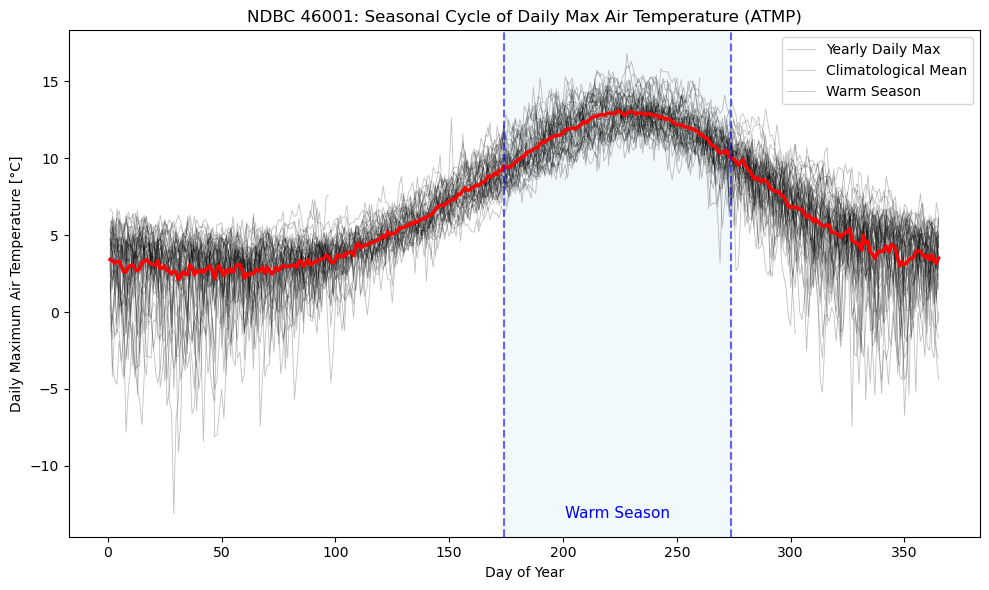

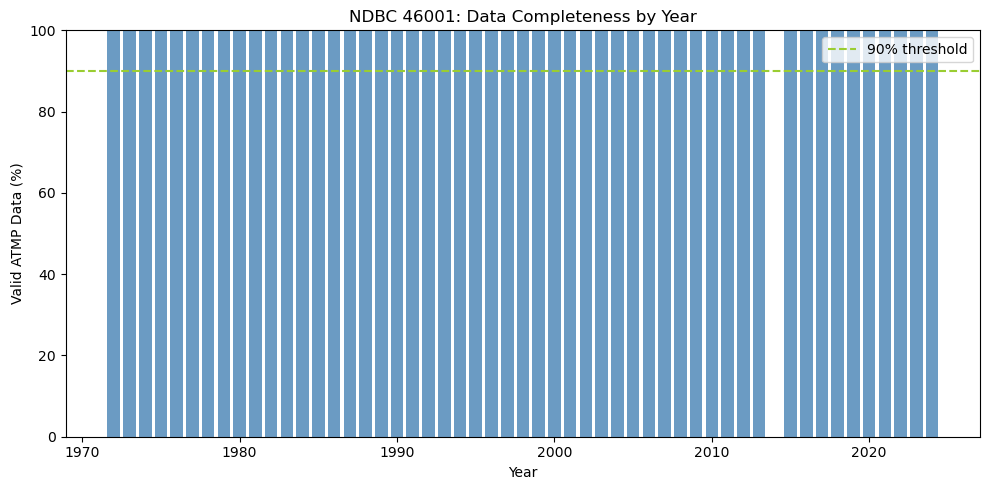

In [6]:
# Use df_filled for smooth visualization
plot_dailymax_seasonal_cycle(mean_temps_df, target_station)

# Use df_raw for statistical analysis (GEV, PDF, etc.)
plot_completeness(completeness, target_station)

### Temperature Anomaly Representation from Seasonal Cycle

In [7]:
# First get the warm season data
buoy_46001_warm, (warm_start, warm_center, warm_end) = get_warm_season_data(mean_temps_df)
print(f"Identified warm season for buoy 46001:")
print(f"Start day: {warm_start}")
print(f"Peak temperature day: {warm_center}")
print(f"End day: {warm_end}")

# Calculate anomalies using only warm season data
daily_maxes = buoy_46001_warm.groupby(['year', 'day_of_year'])['ATMP'].max().reset_index()

# pivot: rows = day_of_year, columns = year, values = ATMP
pivot = daily_maxes.pivot(index='day_of_year', columns='year', values='ATMP')

# Compute the climatological mean for warm season
mean_cycle = pivot.mean(axis=1)

# subtract from the mean to get anomalies
anomalies = pivot.subtract(mean_cycle, axis=0)

# anomalies now has same shape but only for warm season days
# values show °C anomaly relative to the daily climatology

print(f"\nWarm season anomalies sanity check:")
print(f"Mean of means: {anomalies.mean().mean():.4f}°C") 
print(f"Shape of anomalies matrix: {anomalies.shape}")



Identified warm season for buoy 46001:
Start day: 174
Peak temperature day: 224
End day: 274

Warm season anomalies sanity check:
Mean of means: -0.0443°C
Shape of anomalies matrix: (101, 53)


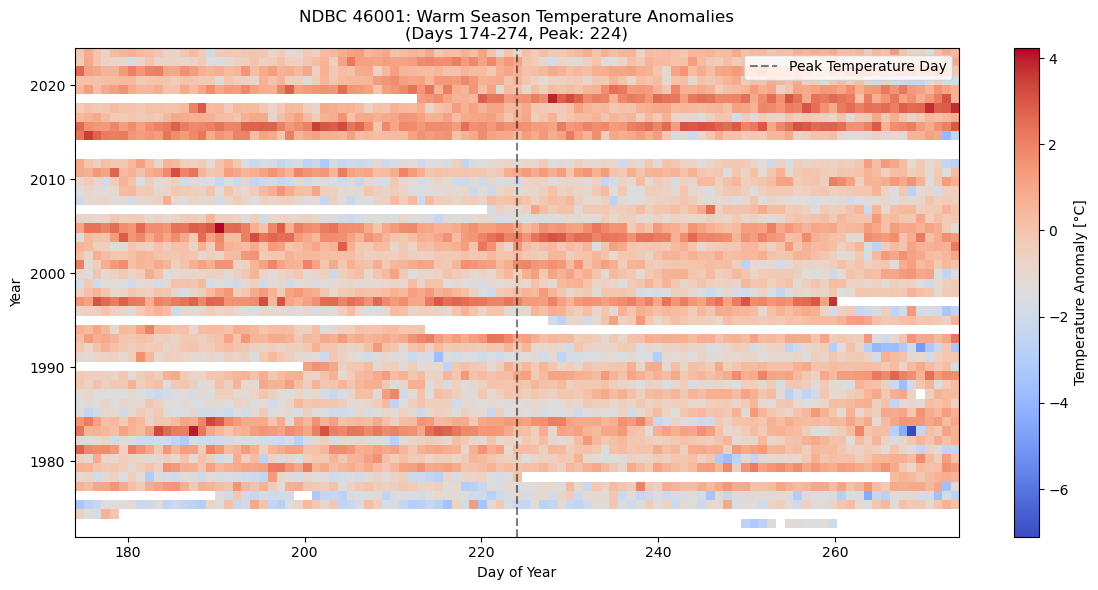

In [8]:
# Heatmap representation of warm season anomalies
plt.figure(figsize=(12,6))
plt.imshow(anomalies.T, aspect='auto', cmap='coolwarm', 
           extent=[warm_start, warm_end, anomalies.columns.min(), anomalies.columns.max()],
           origin='lower')
plt.colorbar(label="Temperature Anomaly [°C]")

# Add marker for peak temperature day
plt.axvline(warm_center, color='black', linestyle='--', alpha=0.5, label='Peak Temperature Day')

plt.xlabel("Day of Year")
plt.ylabel("Year")
plt.title(f"NDBC {target_station}: Warm Season Temperature Anomalies\n(Days {warm_start}-{warm_end}, Peak: {warm_center})")
plt.legend()
plt.tight_layout()
plt.show()

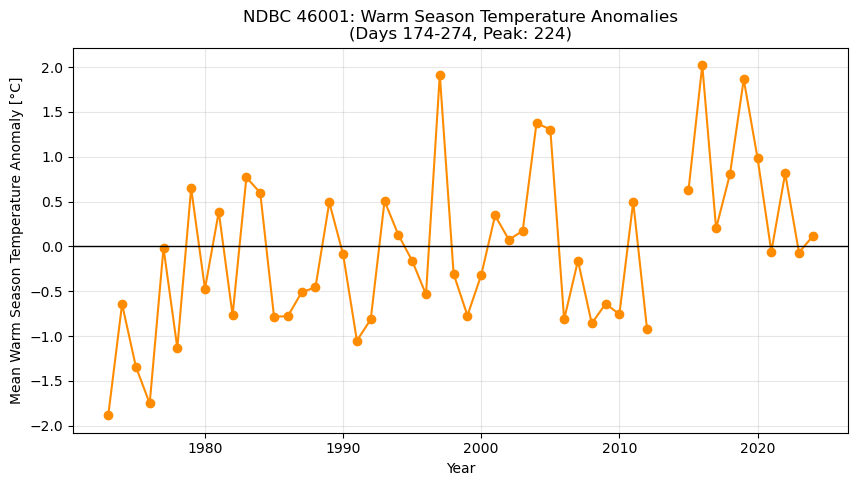

In [9]:
# Time series of warm season temperature anomalies
yearly_anom = anomalies.mean(axis=0)
plt.figure(figsize=(10,5))
plt.plot(yearly_anom.index, yearly_anom.values, marker='o', color='darkorange')
plt.axhline(0, color='black', lw=1)
plt.xlabel("Year")
plt.ylabel("Mean Warm Season Temperature Anomaly [°C]")
plt.title(f"NDBC {target_station}: Warm Season Temperature Anomalies\n(Days {warm_start}-{warm_end}, Peak: {warm_center})")
plt.grid(True, alpha=0.3)
plt.show()

### Variance & Skew of Seasonal Temperature Cycle Trends


In [10]:
yearly_var = pivot.var(axis = 0)
yearly_skew = pivot.apply(skew, axis = 0)
# Interpolate across missing or NaN years for smoother trend visualization



In [11]:
# Diagnostic: Check data coverage for years with missing skewness
print("Checking data coverage per year:\n")
for year in pivot.columns:
    valid_count = pivot[year].notna().sum()
    has_var = not pd.isna(yearly_var[year]) if year in yearly_var.index else False
    has_skew = not pd.isna(yearly_skew[year]) if year in yearly_skew.index else False
    print(f"Year {year}: {valid_count} valid days | Variance: {has_var} | Skewness: {has_skew}")
    
print(f"\nYears with variance but no skewness:")
problem_years = []
for year in pivot.columns:
    if year in yearly_var.index and year in yearly_skew.index:
        if not pd.isna(yearly_var[year]) and pd.isna(yearly_skew[year]):
            problem_years.append(year)
            print(f"  {year}: {pivot[year].notna().sum()} valid days")


Checking data coverage per year:

Year 1972: 0 valid days | Variance: False | Skewness: False
Year 1973: 10 valid days | Variance: True | Skewness: False
Year 1974: 5 valid days | Variance: True | Skewness: False
Year 1975: 101 valid days | Variance: True | Skewness: True
Year 1976: 83 valid days | Variance: True | Skewness: False
Year 1977: 101 valid days | Variance: True | Skewness: True
Year 1978: 59 valid days | Variance: True | Skewness: False
Year 1979: 101 valid days | Variance: True | Skewness: True
Year 1980: 101 valid days | Variance: True | Skewness: True
Year 1981: 101 valid days | Variance: True | Skewness: True
Year 1982: 101 valid days | Variance: True | Skewness: True
Year 1983: 101 valid days | Variance: True | Skewness: True
Year 1984: 101 valid days | Variance: True | Skewness: True
Year 1985: 101 valid days | Variance: True | Skewness: True
Year 1986: 101 valid days | Variance: True | Skewness: True
Year 1987: 100 valid days | Variance: True | Skewness: False
Year 1

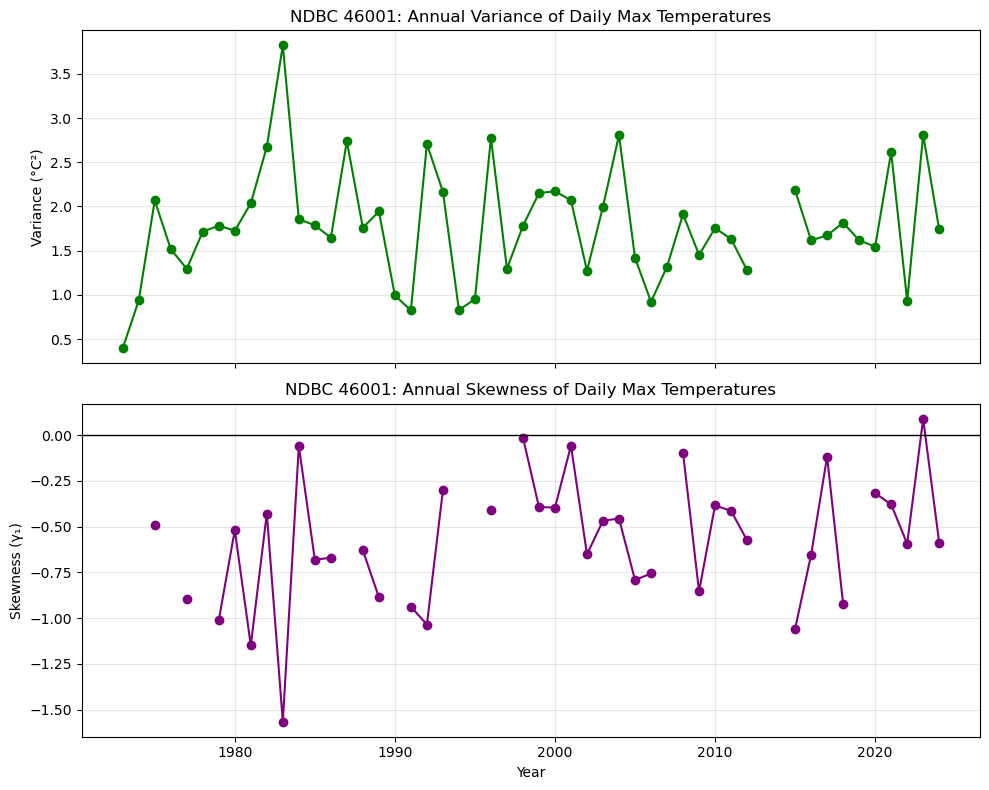

In [12]:
# Ensure continuous yearly spacing for plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# variance, requires at least two daily values to compute
axes[0].plot(yearly_var.index, yearly_var.values, marker='o', color='green')
axes[0].set_ylabel("Variance (°C²)")
axes[0].set_title(f"NDBC {target_station}: Annual Variance of Daily Max Temperatures")
axes[0].grid(True, alpha=0.3)

# skewness requires at least 2 valid daily maxima from 
axes[1].plot(yearly_skew.index, yearly_skew.values, marker='o', color='purple')
axes[1].axhline(0, color='black', lw=1)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Skewness (γ₁)")
axes[1].set_title(f"NDBC {target_station}: Annual Skewness of Daily Max Temperatures")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Where Did All my Completed Data Go?

In [13]:
mean_temps_df

,year,day_of_year,date,ATMP
0,1972,1,NaT,NaN
1,1972,2,NaT,NaN
2,1972,3,NaT,NaN
3,1972,4,NaT,NaN
4,1972,5,NaT,NaN
...,...,...,...,...
19340,2024,361,NaT,NaN
19341,2024,362,NaT,NaN
19342,2024,363,NaT,NaN
19343,2024,364,NaT,NaN


In [14]:
coverage = mean_temps_df.groupby("year")["ATMP"].count()
print(coverage.sort_index())


year
1972     85
1973    139
1974    200
1975    365
1976    269
1977    365
1978    241
1979    334
1980    365
1981    365
1982    365
1983    362
1984    365
1985    365
1986    365
1987    364
1988    365
1989    365
1990    248
1991    339
1992    365
1993    348
1994     66
1995    138
1996    365
1997    334
1998    364
1999    365
2000    365
2001    365
2002    365
2003    365
2004    253
2005    365
2006    315
2007    145
2008    365
2009    365
2010    365
2011    365
2012    365
2013     94
2014      0
2015    197
2016    365
2017    365
2018    365
2019    250
2020    365
2021    270
2022    125
2023    206
2024    310
Name: ATMP, dtype: int64


### Cleaning NBDC Data by Lat/Lon for State Seperation

In [15]:
table_url = "https://www.ndbc.noaa.gov/data/stations/station_table.txt"
txt = requests.get(table_url).text

rows = []
for line in txt.splitlines():
    if '|' not in line:
        continue
    station = line.split('|', 1)[0].strip()
    m = re.search(r'([0-9.]+)\s*([NS])\s+([0-9.]+)\s*([EW])', line)
    if not m:
        continue
    lat = float(m.group(1)) * (1 if m.group(2) == 'N' else -1)
    lon = float(m.group(3)) * (1 if m.group(4) == 'E' else -1)
    rows.append((station, lat, lon))

coords_df = pd.DataFrame(rows, columns=["station", "lat", "lon"])


In [16]:
stdmet_url = "https://www.ndbc.noaa.gov/data/historical/stdmet/"
soup = BeautifulSoup(requests.get(stdmet_url).text, "html.parser")

years = {}
for a in soup.find_all("a", href=True):
    h = a["href"]
    m = re.match(r"(\w+)h(\d{4})\.txt\.gz$", h)
    if m:
        st, yr = m.groups()
        years.setdefault(st, set()).add(int(yr))

years_df = pd.DataFrame(
    [(st, len(yrs)) for st, yrs in years.items()],
    columns=["station", "years_logged"]
)

df = coords_df.merge(years_df, on="station", how="left").fillna({"years_logged": 0})
df

,station,lat,lon,years_logged
0,0y2w3,44.794,-87.313,4.0
1,13001,12.000,-23.000,0.0
2,13002,21.000,-23.000,0.0
3,13008,15.000,-38.000,0.0
4,13009,8.000,-38.000,0.0
...,...,...,...,...
1910,ygnn6,43.262,-79.064,16.0
1911,ykrv2,37.251,-76.342,18.0
1912,yktv2,37.227,-76.479,20.0
1913,yrsv2,37.414,-76.712,0.0


In [17]:
df = df.sort_values(by = 'years_logged', ascending = False).reset_index(drop = True)
#df = pd.DataFrame(data).loc[(lambda d: (d['lat'] > 10 ) & (d['lon'] < 10))]
#df = df.sort_values("years_logged", ascending = False).reset_index(drop = True)
df

,station,lat,lon,years_logged
0,46001,56.296,-148.027,53.0
1,42002,25.950,-93.780,52.0
2,42001,25.926,-89.662,50.0
3,41002,31.743,-74.955,50.0
4,46002,42.560,-130.523,47.0
...,...,...,...,...
1910,46146,49.340,-123.730,0.0
1911,46145,54.370,-132.420,0.0
1912,46134,48.650,-123.500,0.0
1913,46132,49.780,-127.890,0.0


In [18]:
#filter for west coast buoy stations
west_coast = df[
    (df["lat"] >= 32) & (df["lat"] <= 49) & 
    (df["lon"] <= -117) & (df["lon"] >= -125)
]
#now by longest data record
west_coast_sorted = west_coast.sort_values("years_logged", ascending=False).reset_index(drop=True)

print(west_coast_sorted.head(10))

  station     lat      lon  years_logged
0   46011  34.937 -120.999          44.0
1   46012  37.356 -122.881          44.0
2   46013  38.235 -123.317          44.0
3   46014  39.225 -123.980          44.0
4   46026  37.750 -122.838          43.0
5   46025  33.755 -119.045          43.0
6   46022  40.716 -124.540          43.0
7   46027  41.840 -124.382          42.0
8   46028  35.770 -121.903          42.0
9   sisw1  48.321 -122.831          41.0


In [19]:
#filter by west coast state 
def classify_state(lat, lon):
    if 42 <= lat <= 49 and -125 <= lon <= -122:
        return "WA/OR"
    elif 32 <= lat < 42 and -125 <= lon <= -117:
        return "CA"
    elif 40 <= lat <= 45 and -125 <= lon <= -120:
        return "OR"
    elif 46 <= lat <= 49 and -125 <= lon <= -120:
        return "WA"
    else:
        return "Other"

df.loc[:,["state"]] = df.apply(lambda r: classify_state(r["lat"], r["lon"]), axis=1)
df


,station,lat,lon,years_logged,state
0,46001,56.296,-148.027,53.0,Other
1,42002,25.950,-93.780,52.0,Other
2,42001,25.926,-89.662,50.0,Other
3,41002,31.743,-74.955,50.0,Other
4,46002,42.560,-130.523,47.0,Other
...,...,...,...,...,...
1910,46146,49.340,-123.730,0.0,Other
1911,46145,54.370,-132.420,0.0,Other
1912,46134,48.650,-123.500,0.0,WA/OR
1913,46132,49.780,-127.890,0.0,Other


In [20]:
df_ca = df[df['state'] == 'CA']
df_ca

,station,lat,lon,years_logged,state
16,46011,34.937,-120.999,44.0,CA
17,46012,37.356,-122.881,44.0,CA
18,46013,38.235,-123.317,44.0,CA
19,46014,39.225,-123.980,44.0,CA
23,46026,37.750,-122.838,43.0,CA
...,...,...,...,...,...
1857,eazc1,36.846,-121.754,0.0,CA
1861,46412,32.400,-120.582,0.0,CA
1863,ehsc1,36.835,-121.738,0.0,CA
1880,46090,32.876,-120.718,0.0,CA


In [21]:
df_waor = df[df['state'] == 'WA/OR']
df_waor

,station,lat,lon,years_logged,state
42,sisw1,48.321,-122.831,41.0,WA/OR
46,wpow1,47.662,-122.435,41.0,WA/OR
47,desw1,47.675,-124.485,41.0,WA/OR
54,nwpo3,44.613,-124.067,40.0,WA/OR
65,46041,47.352,-124.739,38.0,WA/OR
...,...,...,...,...,...
1871,46116,46.287,-124.016,0.0,WA/OR
1873,hmno3,46.203,-123.952,0.0,WA/OR
1889,46123,47.375,-123.008,0.0,WA/OR
1908,gptw1,46.273,-123.767,0.0,WA/OR


### Granular Data Loading for Trial Station GEV/PDF Analysis

In [22]:
#cell with all computation and data loading

station1 = "rcmc1"  
station2 = "ftpc1"  

annual_max1 = collect_station_max(station1)
annual_max2 = collect_station_max(station2)

print(f"\n{station1} Annual Max ATMP:")
print(annual_max1)
print(f"\n{station2} Annual Max ATMP:")
print(annual_max2)

Found 19 files for station rcmc1
Found 20 files for station ftpc1
Found 20 files for station ftpc1

rcmc1 Annual Max ATMP:
2007    29.7
2008    34.2
2009    30.9
2010    34.8
2011    28.4
2012    29.7
2013    30.2
2014    32.1
2015    33.2
2016    32.9
2017    35.5
2018    27.9
2019    32.9
2020    32.5
2021    28.8
2022    34.4
2023    31.4
2024    33.5
dtype: float64

ftpc1 Annual Max ATMP:
2007    27.1
2008    31.0
2009    30.6
2010    31.9
2011    25.9
2012    27.6
2013    26.5
2014    30.3
2015    28.7
2016    29.7
2017    34.4
2018    24.3
2019    32.3
2020    32.1
2021    25.8
2022    34.1
2023    30.3
2024    31.2
dtype: float64

rcmc1 Annual Max ATMP:
2007    29.7
2008    34.2
2009    30.9
2010    34.8
2011    28.4
2012    29.7
2013    30.2
2014    32.1
2015    33.2
2016    32.9
2017    35.5
2018    27.9
2019    32.9
2020    32.5
2021    28.8
2022    34.4
2023    31.4
2024    33.5
dtype: float64

ftpc1 Annual Max ATMP:
2007    27.1
2008    31.0
2009    30.6
2010    31.9
2011  

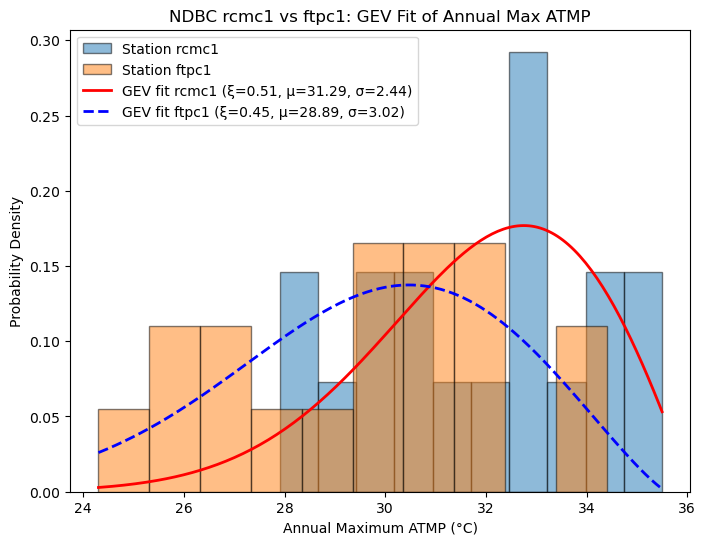

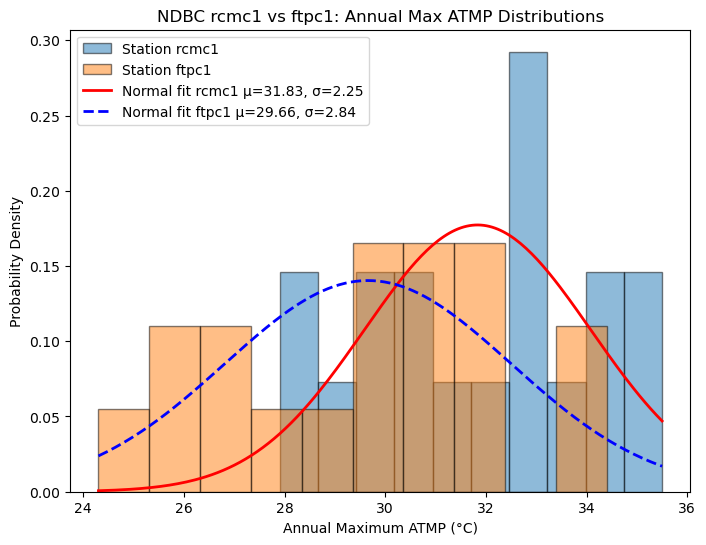

In [23]:
from scipy.stats import genextreme
#plotting GEV and PDF over histograms

#generalized extreme value distribution
plt.figure(figsize=(8,6))

#empirical dist. from histograms
plt.hist(annual_max1.values, bins=10, density=True, alpha=0.5,
         edgecolor="black", label=f"Station {station1}")
plt.hist(annual_max2.values, bins=10, density=True, alpha=0.5,
         edgecolor="black", label=f"Station {station2}")

#fitting GEV distributions
shape1, loc1, scale1 = genextreme.fit(annual_max1.values)
shape2, loc2, scale2 = genextreme.fit(annual_max2.values)

x = np.linspace(min(annual_max1.min(), annual_max2.min()),
                max(annual_max1.max(), annual_max2.max()), 200)

#gev pdfs
plt.plot(x, genextreme.pdf(x, shape1, loc=loc1, scale=scale1), "r-", lw=2,
         label=f"GEV fit {station1} (ξ={shape1:.2f}, μ={loc1:.2f}, σ={scale1:.2f})")
plt.plot(x, genextreme.pdf(x, shape2, loc=loc2, scale=scale2), "b--", lw=2,
         label=f"GEV fit {station2} (ξ={shape2:.2f}, μ={loc2:.2f}, σ={scale2:.2f})")

plt.xlabel("Annual Maximum ATMP (°C)")
plt.ylabel("Probability Density")
plt.title(f"NDBC {station1} vs {station2}: GEV Fit of Annual Max ATMP")
plt.legend()
plt.show()

#plotting histograms and pdfs
plt.figure(figsize=(8,6))

plt.hist(annual_max1.values, bins=10, density=True, alpha=0.5,
         edgecolor="black", label=f"Station {station1}")
plt.hist(annual_max2.values, bins=10, density=True, alpha=0.5,
         edgecolor="black", label=f"Station {station2}")

#fitting normal distributions
mu1, sigma1 = norm.fit(annual_max1.values)
mu2, sigma2 = norm.fit(annual_max2.values)

x = np.linspace(min(annual_max1.min(), annual_max2.min()),
                max(annual_max1.max(), annual_max2.max()), 200)

#pdf 
plt.plot(x, norm.pdf(x, mu1, sigma1), "r-", lw=2,
         label=f"Normal fit {station1} μ={mu1:.2f}, σ={sigma1:.2f}")
plt.plot(x, norm.pdf(x, mu2, sigma2), "b--", lw=2,
         label=f"Normal fit {station2} μ={mu2:.2f}, σ={sigma2:.2f}")

plt.xlabel("Annual Maximum ATMP (°C)")
plt.ylabel("Probability Density")
plt.title(f"NDBC {station1} vs {station2}: Annual Max ATMP Distributions")
plt.legend()
plt.show()